# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Подготовка данных

In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

import optuna
import catboost
import lightgbm as lgb

import timeit
import warnings
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
pd.options.display.float_format = '{:0.3f}'.format
pd.options.mode.chained_assignment = None

sns.set_theme(context='paper',
              palette='muted',
              style='whitegrid',
              font_scale=1.1,
              rc={'lines.linewidth': 1.25})

plt.rcParams.update({'grid.linewidth': 0.5,
                     'grid.alpha': 0.5,
                     'figure.constrained_layout.use': True,
                     'figure.figsize': (10, 6)})

%config InlineBackend.figure_format = 'retina'

Загрузим и посмотрим данные.

In [3]:
df = pd.read_csv('autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
df.head()

DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
0 2016-03-24 11:52:17    480         NaN              1993  manual      0   
1 2016-03-24 10:58:45  18300       coupe              2011  manual    190   
2 2016-03-14 12:52:21   9800         suv              2004    auto    163   
3 2016-03-17 16:54:04   1500       small              2001  manual     75   
4 2016-03-31 17:25:20   3600       small              2008  manual     69   

   Model  Kilometer  RegistrationMonth  FuelType       Brand NotRepaired  \
0   golf     150000                  0    petrol  volkswagen         NaN   
1    NaN     125000                  5  gasoline        audi         yes   
2  grand     125000                  8  gasoline        jeep         NaN   
3   golf     150000                  6    petrol  volkswagen          no   
4  fabia      90000                  7  gasoline       skoda          no   

  DateCreated  NumberOfPictures  PostalCode            LastSeen  
0  2016-03-24                 0       70435 2016-04-07 03:16:57  
1  2016-03-24                 0       66954 2016-04-07 01:46:50  
2  2016-03-14                 0       90480 2016-04-05 12:47:46  
3  2016-03-17                 0       91074 2016-03-17 17:40:17  
4  2016-03-31                 0       60437 2016-04-06 10:17:21

## EDA

Воспользуемся библиотекой pandas-profiling для краткого анализа данных.

In [4]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Выделим признаки, в которых есть NaN и оценим сколько данных мы потеряем удалив их.

In [5]:
columns_with_na = list(
    df.isna()
    .sum()
    .where(lambda x: x > 0)
    .dropna()
    .index
)
columns_with_na

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']

In [6]:
for i in range(len(columns_with_na)+1):
    ratio = df.dropna(axis=0,
                      how="any",
                      subset=columns_with_na,
                      thresh=i) \
              .shape[0] / df.shape[0]
    print(f'Порог = {i} - {ratio:.2f}')

Порог = 0 - 1.00
Порог = 1 - 0.99
Порог = 2 - 0.98
Порог = 3 - 0.95
Порог = 4 - 0.88
Порог = 5 - 0.69


> Оптимальным будет удалить данные, в которых в одном объекте присутствует сразу 3 и более пропуска (Порог = 3).

По распределению цен заметна группа машин с очень низкой стоимость, возможно это металлолом после аварии или авто в очень плохом состоянии. Поэтому для сервиса по оценке рыночной стоимости обычного автотранспорта такие данные не релевантны.

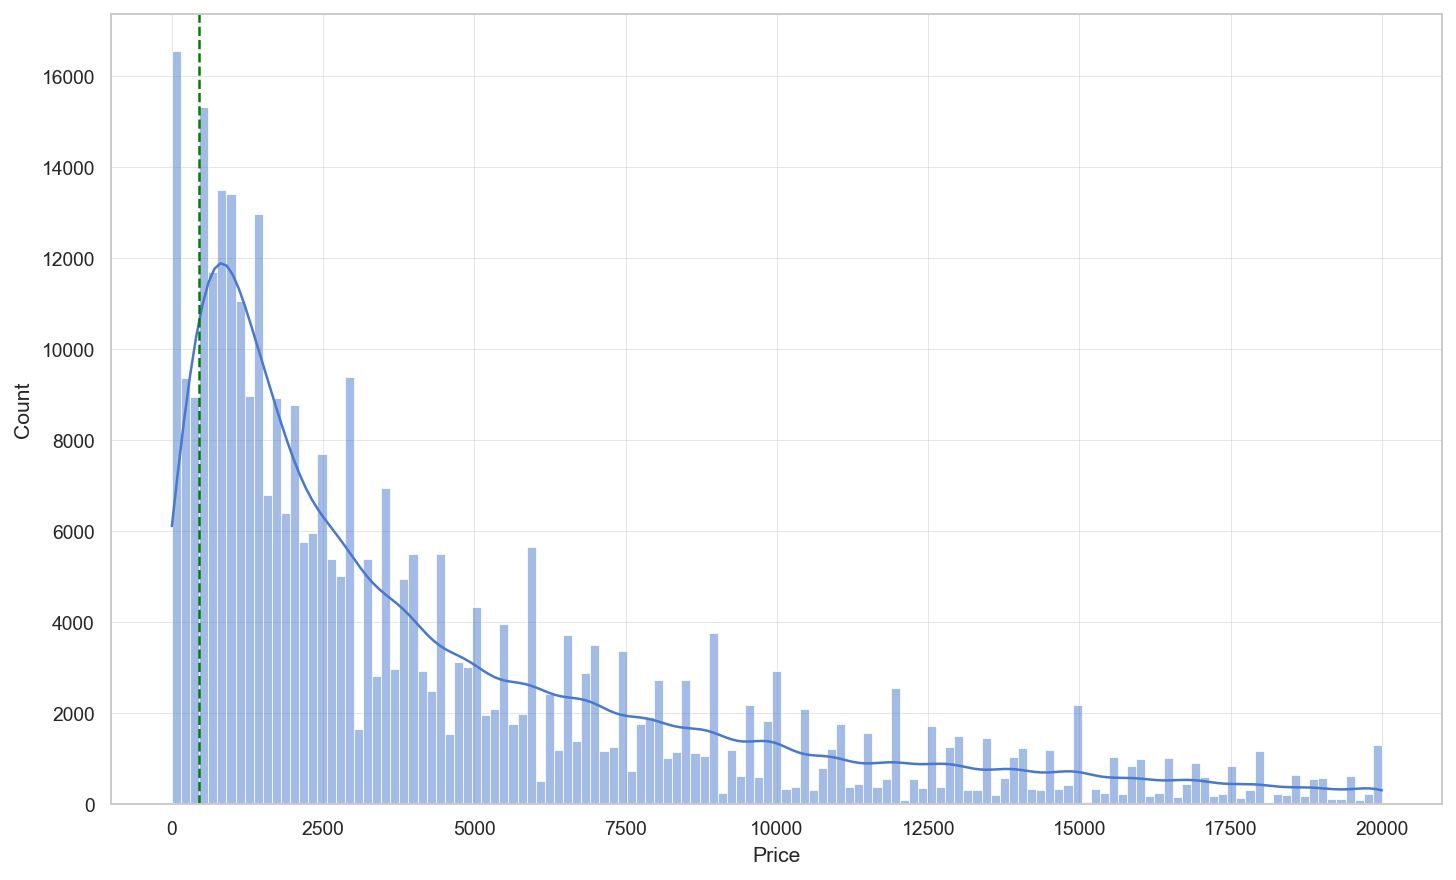

In [7]:
sns.histplot(df.Price, kde=True)
plt.axvline(x=450, ls='--', color='green')
plt.show()

Визуализируем как наличие ремонтных работ влияет на стоимость машины.

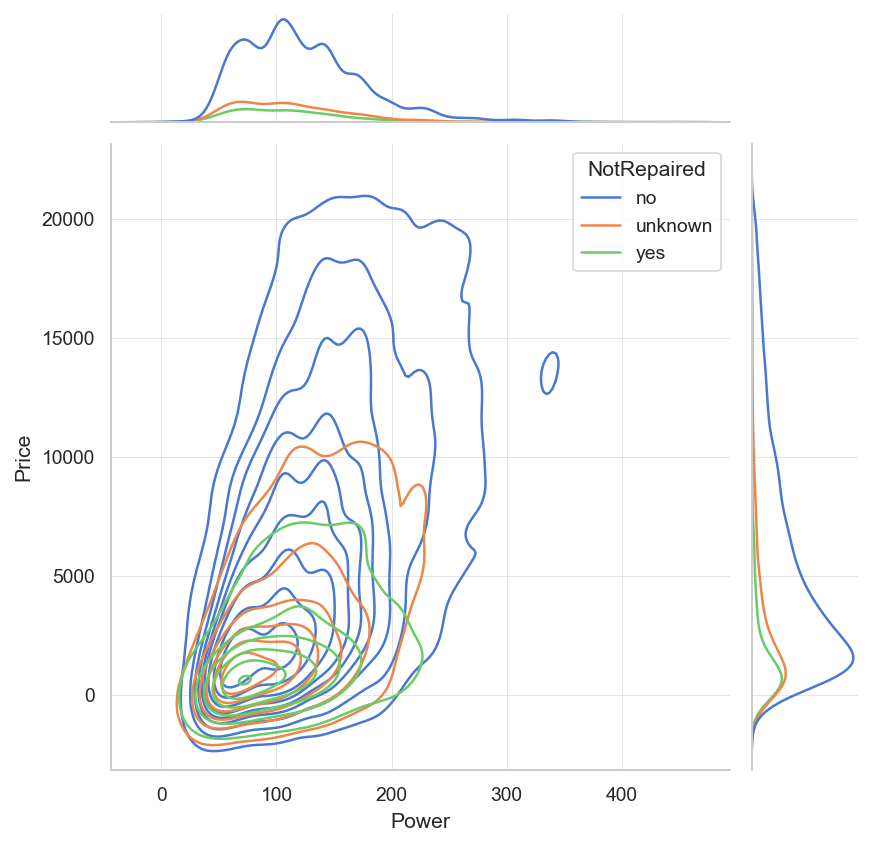

In [8]:
sns.jointplot(data=df.fillna('unknown').sample(12000).query('0 < Power < 500'),
              x="Power", y="Price", hue='NotRepaired',
              kind="kde");

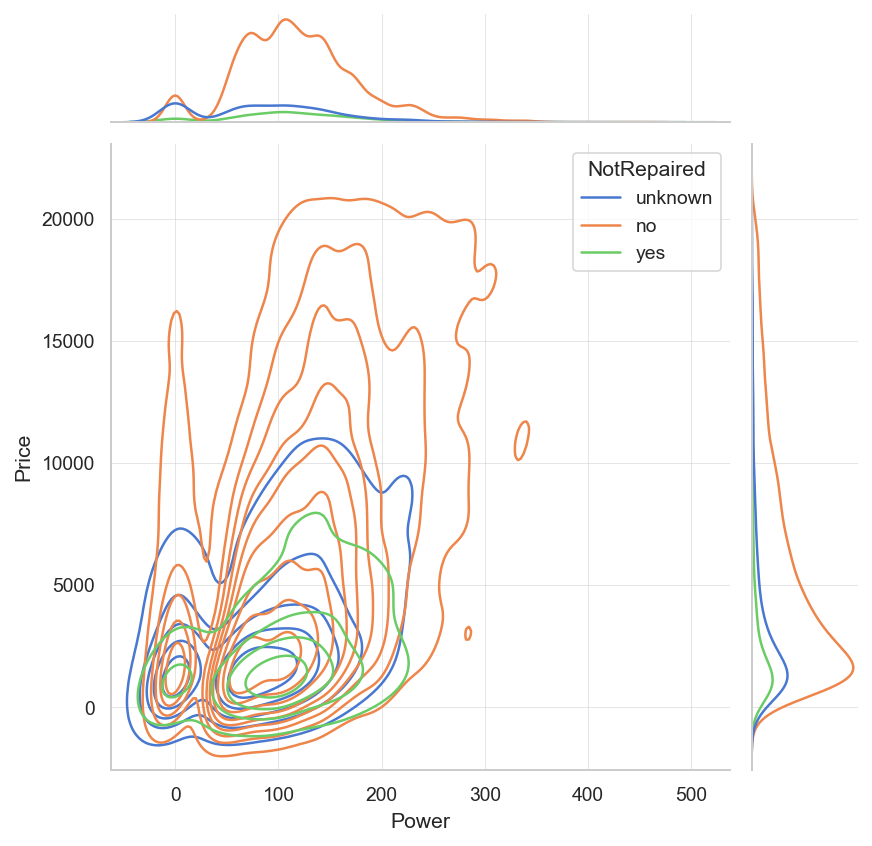

In [19]:
# Включим авто с Power равной 0.
sns.jointplot(data=df.fillna('unknown').sample(12000).query('Power < 500'),
              x="Power", y="Price", hue='NotRepaired',
              kind="kde");

Boxplot по NotRepaired.

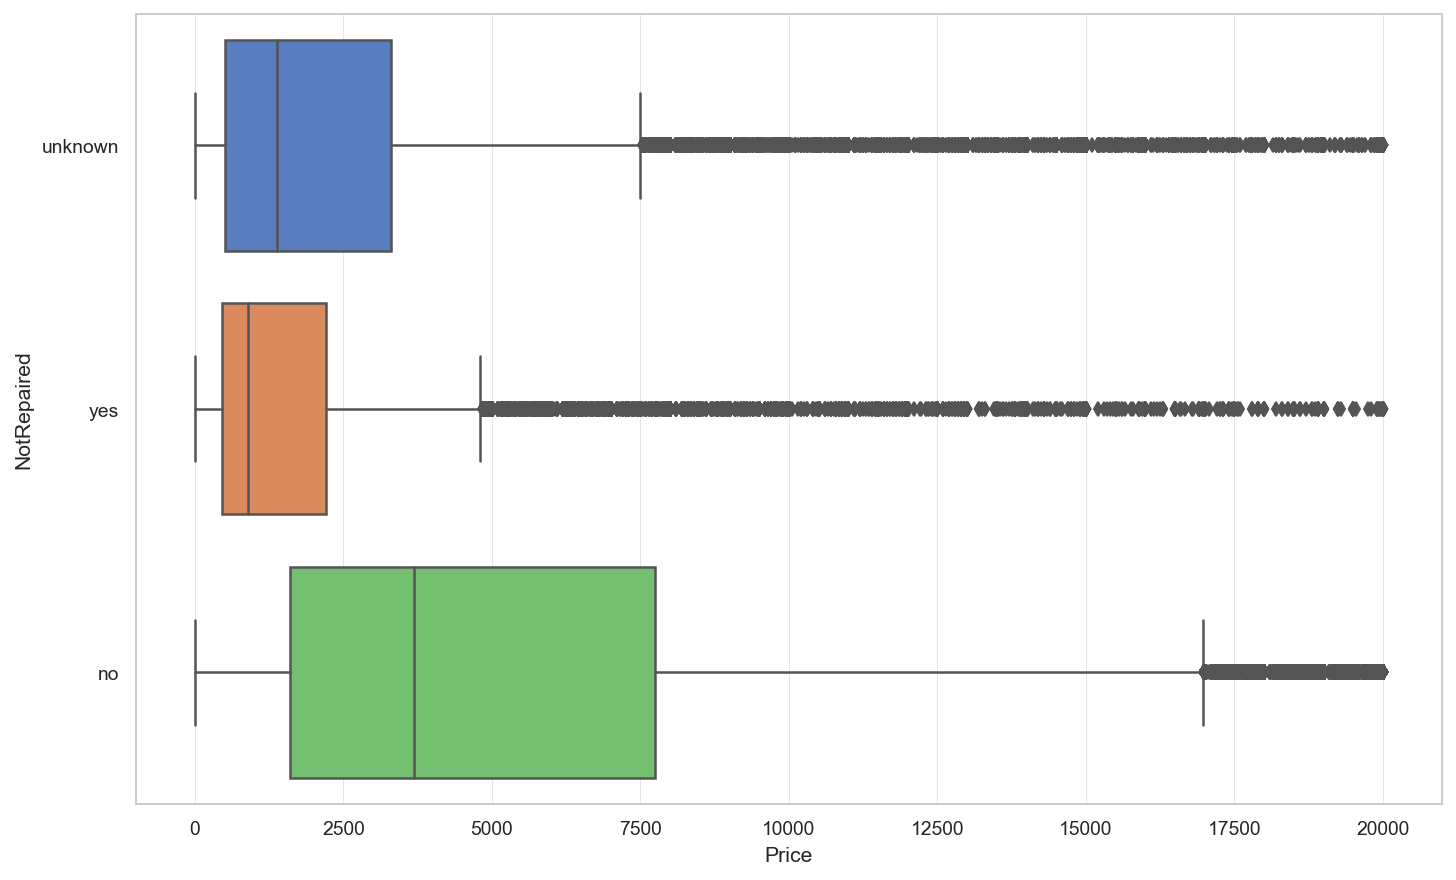

In [10]:
sns.boxplot(data=df.fillna('unknown'), y='NotRepaired', x='Price', orient='h');

Оценим связь года регистрации автомобиля с ценой.

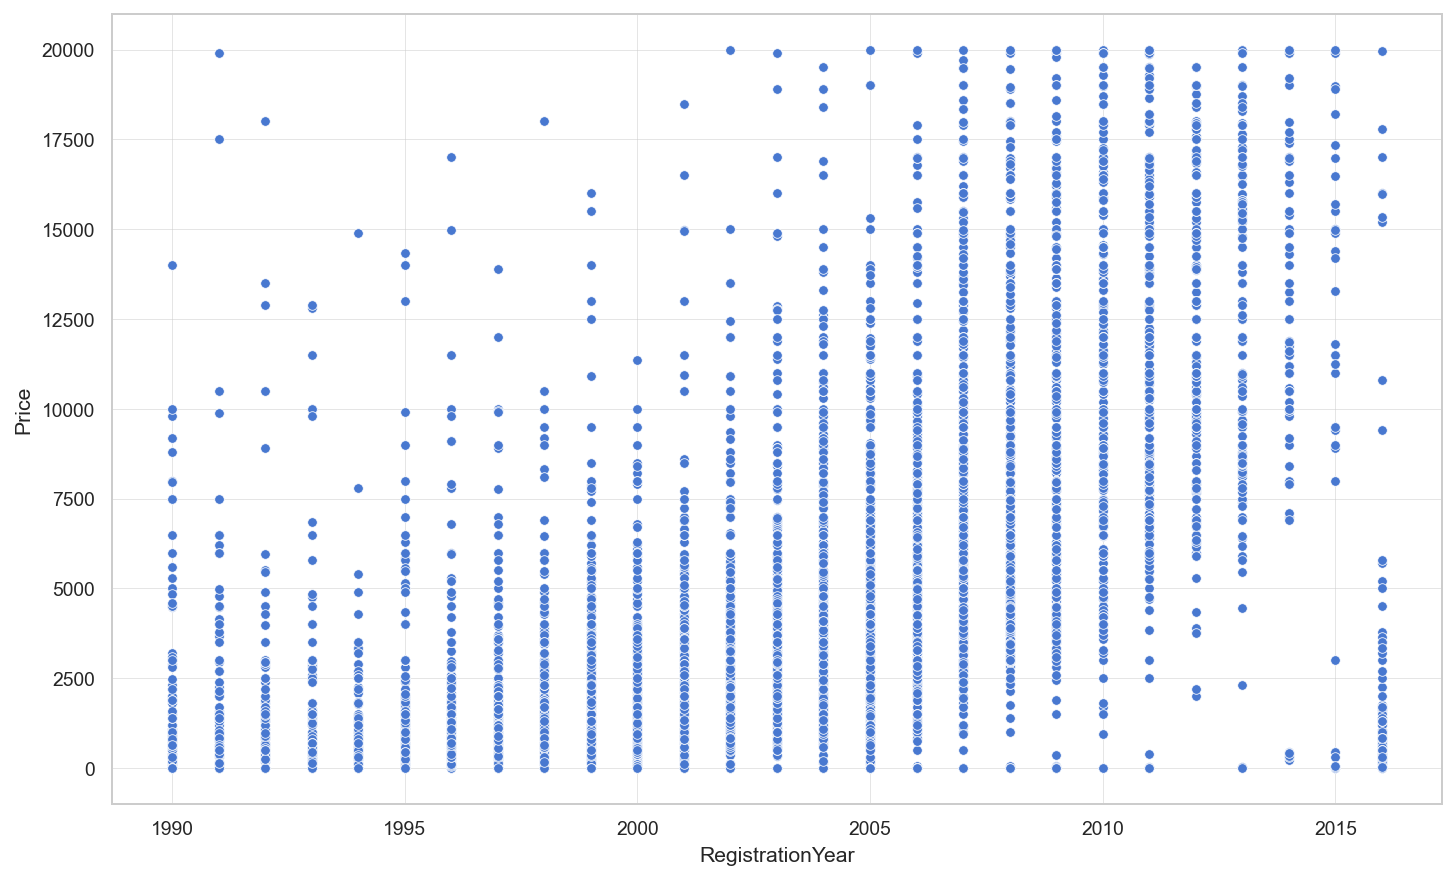

In [11]:
sns.scatterplot(data=df.sample(10000).query('1990 <= RegistrationYear < 2016 or (RegistrationYear == 2016 and RegistrationMonth <= 3)'),
                x='RegistrationYear', y='Price');

С ростом мощности стоимость авто растет.

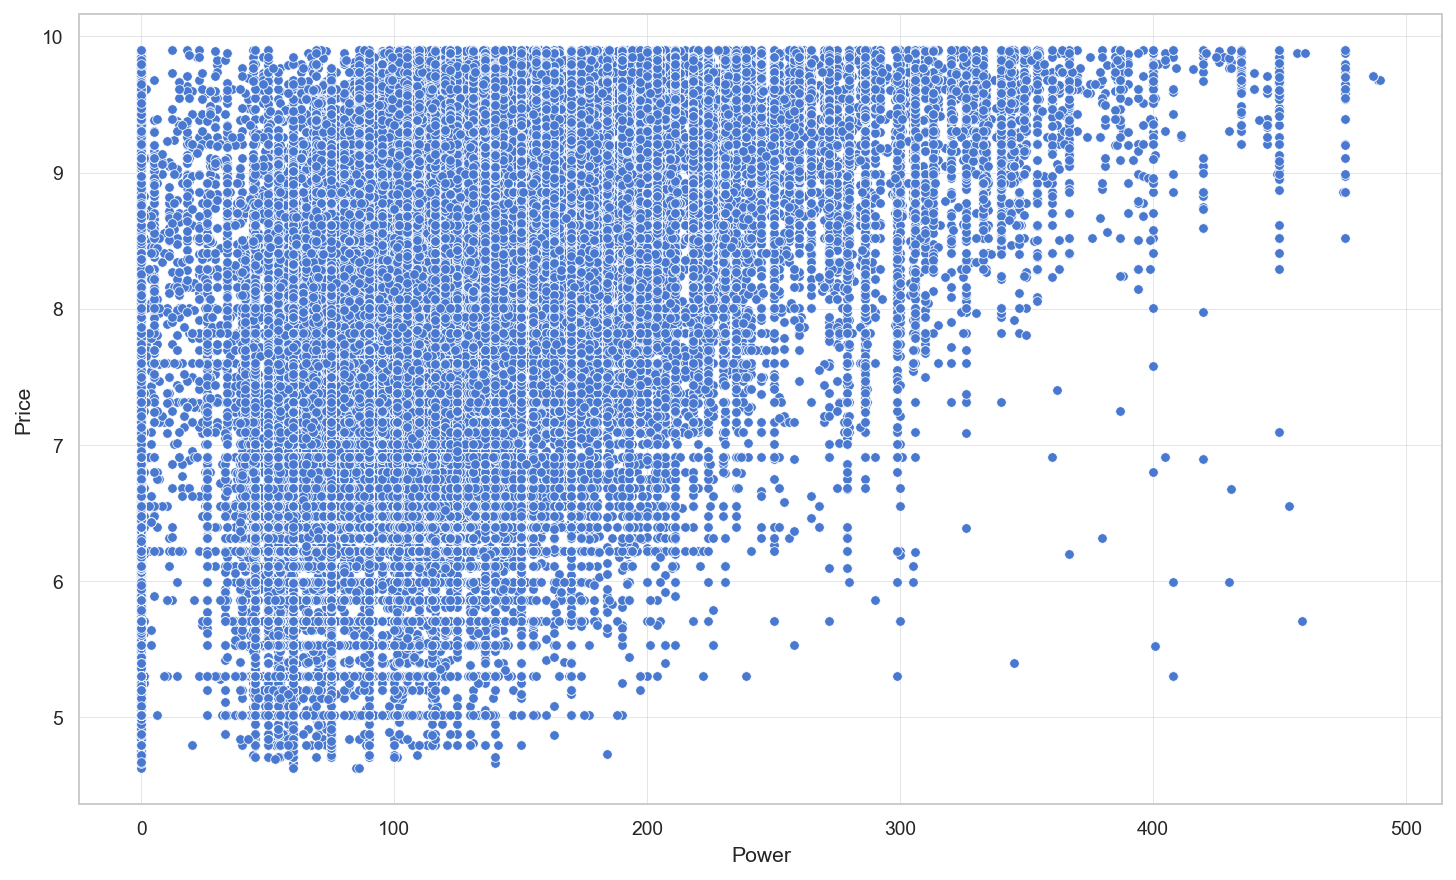

In [12]:
sns.scatterplot(data=df.query('Power < 500 and Price > 100'),
                x='Power', y=np.log1p(df["Price"]));

Из PostalCode можно взять информацию по региону. Корреляция пусть и слабая есть по первым двум цифрам индекса.

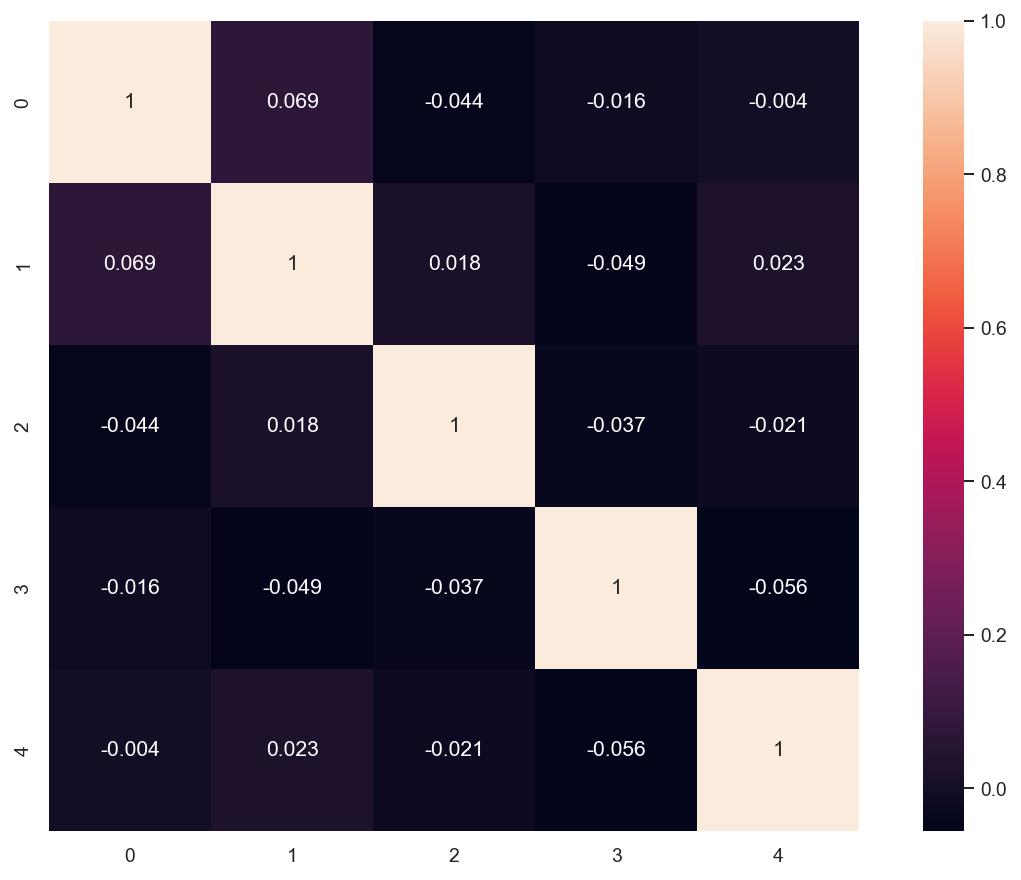

In [13]:
sns.heatmap(
    np.corrcoef([
        df["Price"],
        df.PostalCode.apply(lambda x: int(str(x)[0])),
        df.PostalCode.apply(lambda x: int(str(x)[1])),
        df.PostalCode.apply(lambda x: int(str(x)[2])),
        df.PostalCode.apply(lambda x: int(str(x)[3]))
    ]), annot=True, square=True
);

Пробег в километрах потенциально можно отнести к категориям.

Видно, что в основном в ходу б/у машины с пробегом 150000+ км.

In [14]:
df.Kilometer.value_counts()

150000    238209
125000     36454
100000     14882
90000      11567
80000      10047
70000       8593
60000       7444
5000        6397
50000       6232
40000       4911
30000       4436
20000       3975
10000       1222
Name: Kilometer, dtype: int64

## Выводы

* Найдены полные дупликаты в данных (2 лишних объекта).
* В признаке NumberOfPictures (количество фотографий автомобиля), вероятно, ошибка данных, т.к. содержаться только нули. Придется удалить.
* Есть объявления со слишком низкой ценой, те, что ниже 500 евро стоит удалить.
* DateCrawled (дата скачивания анкеты из базы), DateCreated (дата создания анкеты) и LastSeen (дата последней активности пользователя) не представляют интерес и должны быть удалены.
* Пропуски в VehicleType (тип автомобильного кузова) можно попытаться восстановить по Brand + Model.
* Ограничим RegistrationYear (год регистрации автомобиля) диапазоном 1995 - 2015 (т.к. последняя дата выгрузки из базы - 2016 год, кроме того значения за 2016 год выпадают из общего растущего тренда, предполагающего что более новые машины стоят дороже).
* Power (Мощность) сильно коррелирует с ценой, стоит попытаться восстановить. Убрать NaN и нули. Кроме того, удалить данные с мощность выше 500.
* Пропуски с Model (модель автомобиля) удалим, нет смысла пытаться предсказать стоимость только по бренду.
* В FuelType (тип топлива) пропуски оставим.
* Нули в RegistrationMonth (месяц регистрации автомобиля) означают что месяц не определен.
* NotRepaired (была машина в ремонте или нет) NaN вероятно представлены у моделей, прошедших ремонт.

## Обучение моделей

Основываясь на выводах EDA создадим класс FeatureTransformer для предобработки данных.

In [15]:
class FeatureTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X = X.query('~Model.isna()')
        
        # Удалим полные дубликаты.
        X.drop_duplicates(inplace=True)
        
        # Заполним пропуски и некорректные нулевые значения модой.
        X['VehicleType'] = X.VehicleType.fillna(
            X.groupby(['Brand','Model'])['VehicleType']
              .transform(lambda x: st.mode(x).mode[0])
        )
        X['FuelType'] = X.FuelType.fillna(
            X.groupby(['Brand','Model'])['FuelType']
              .transform(lambda x: st.mode(x).mode[0])
        )
        X = X.where(X.Power > 0)
        X['Power'] = X.Power.fillna(
            X.groupby(['Brand','Model'])['Power']
            .transform('median')
        )
        
        # Отфильтруем интересующие нас данные и удалим лишнее.
        X = X.drop(columns=['DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures'])
        X = X.query('1995 <= RegistrationYear < 2016 and Power < 500')
        
        # Частично удалим данные где много пропусков.
        columns_with_na = list(
            X.isna()
            .sum()
            .where(lambda x: x > 0)
            .dropna()
            .index
        )
        X.dropna(axis=0,
                 how="any",
                 subset=columns_with_na,
                 thresh=3)
        X = X.query('~Power.isna()')
        
        # Заменим NaN на unknown.
        X.fillna('unknown', inplace=True)
        
        # Поменяем тип на категориальный (нужно для lgb).
        X['PostalCode_1'] = pd.Categorical(X.PostalCode.map(lambda x: int(str(x)[0])))
        X['PostalCode_2'] = pd.Categorical(X.PostalCode.map(lambda x: int(str(x)[1])))
        X = X.drop(columns='PostalCode')
        # Для остальных не количественных признаков.
        cols = X.select_dtypes(exclude=np.number).columns
        X[cols] = X[cols].apply(lambda x: x.astype('category'))
        
        return X

Разделим выборку на train и test. Кроме того отфильтруем авто по стоимости.

In [16]:
df = df.query('Price > 500').reset_index(drop=True)

X = df.drop('Price', axis=1)
X = FeatureTransformer().transform(X)
y = df.loc[X.index, 'Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=38)

print(df.shape, X.shape)

(312645, 16) (245240, 12)


In [17]:
X.sample(5, random_state=38)

VehicleType  RegistrationYear Gearbox   Power   Model  Kilometer  \
309355  convertible          2006.000  manual  88.000   micra 100000.000   
286462        wagon          2006.000    auto 150.000  vectra 150000.000   
13363           bus          2005.000    auto 150.000  espace 150000.000   
101873        sedan          2008.000  manual  95.000    colt  80000.000   
56288           bus          2006.000  manual 120.000  zafira 150000.000   

        RegistrationMonth  FuelType       Brand NotRepaired PostalCode_1  \
309355              9.000    petrol      nissan          no            1   
286462              6.000  gasoline        opel          no            5   
13363               6.000  gasoline     renault          no            2   
101873             11.000    petrol  mitsubishi          no            9   
56288               3.000  gasoline        opel          no            6   

       PostalCode_2  
309355            2  
286462            8  
13363             0  
101873            1  
56288             8

Создадим датасеты для lgb и cat_features.

In [18]:
cat_features = X.select_dtypes(exclude=np.number).columns.tolist()
train_set = lgb.Dataset(X_train, label=y_train)
test_set = lgb.Dataset(X_test, label=y_test)

## LightGBM

Воспользуемся Optuna для поиска гиперпараметров.

In [20]:
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbose':-1,
        'max_depth': trial.suggest_int('max_depth', 3, 100),
        'num_iterations': trial.suggest_int('num_iterations', 100, 2000),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
        'seed': 38,
    }
 
    model = lgb.train(params=params, train_set=train_set, num_boost_round=900)
    y_hat = model.predict(X_test)
    # Вместо вариационной выборки использую y_test, что не совсем корректно.
    return mean_squared_error(y_test, y_hat, squared=False)
 
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100);

print('Оптимальные гиперпараметры:', study.best_trial.params)
print(f'Лучший RMSE: {study.best_value:.1f}', )

Оптимальные гиперпараметры: {'max_depth': 58, 'num_iterations': 1996, 'feature_fraction': 0.7942938950665137}
Лучший RMSE: 1368.9


Посчитаем модель lgb.

In [21]:
# Параметры модели.
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbose':-1,
    'max_depth': 18,
    'num_boost_round':  1250,
    'feature_fraction': 0.80,
    'seed': 38,
}

In [22]:
lgb_t = timeit.repeat('''\
global lgb_rmse
lgb_booster = lgb.train(params=params, train_set=train_set)
lgb_rmse = mean_squared_error(y_test, lgb_booster.predict(X_test), squared=False)
'''
, globals=globals(), number=1, repeat=3)

Результаты кросс-валидации.

In [23]:
cvbooster = lgb.cv(params=params, train_set=train_set, nfold=5,
                   stratified=False, shuffle=True, early_stopping_rounds = 10,
                   eval_train_metric=True, verbose_eval=250)

print(f'Средний RMSE на валидационной выборке: {cvbooster["valid rmse-mean"][-1]:.1f}')

[250]	cv_agg's train rmse: 1338.32 + 1.14954	cv_agg's valid rmse: 1430.08 + 7.7944
[500]	cv_agg's train rmse: 1264.94 + 2.14058	cv_agg's valid rmse: 1409.51 + 7.95169
[750]	cv_agg's train rmse: 1214.01 + 2.00218	cv_agg's valid rmse: 1399.83 + 7.56928
[1000]	cv_agg's train rmse: 1173.62 + 2.78468	cv_agg's valid rmse: 1393.01 + 7.21766
[1250]	cv_agg's train rmse: 1139.54 + 1.32015	cv_agg's valid rmse: 1388.71 + 6.68904
Средний RMSE на валидационной выборке: 1388.7


## CatBoost

In [24]:
cat_t = timeit.repeat('''\
global cat_rmse
cat_booster = catboost.CatBoostRegressor()
cat_booster.fit(X_train, y_train, cat_features=cat_features,
                early_stopping_rounds=10, verbose=250)
cat_rmse = mean_squared_error(y_test, cat_booster.predict(X_test), squared=False)
'''
, globals=globals(), number=1, repeat=1)

Learning rate set to 0.094281
0:	learn: 4335.4630050	total: 239ms	remaining: 3m 58s
250:	learn: 1500.5384919	total: 21.9s	remaining: 1m 5s
500:	learn: 1448.7998661	total: 43.3s	remaining: 43.1s
750:	learn: 1422.2218556	total: 1m 5s	remaining: 21.6s
999:	learn: 1402.0579315	total: 1m 27s	remaining: 0us


## Linear models и Random Forest

Сделаем трансформер чтобы дополнительно использовать OHE для категориальных признаков.

In [25]:
transformer = ColumnTransformer(
    transformers=[
        ('quantitative',
             StandardScaler(),
             X.select_dtypes(include=np.number).columns.tolist()),
        ('qualitative',
             OneHotEncoder(drop='if_binary', handle_unknown='ignore'),
             cat_features)
])

Для каждой модели сформируем пайнлайн, получим RMSE и среднее время выполнения.

Можно было бы воспользоваться %%timeit или %%time, но у них нет return.

In [26]:
ridge_t = timeit.repeat('''\
global ridge_rmse
ridge_pipe = make_pipeline(transformer, Ridge(alpha=0.1))
y_hat = ridge_pipe.fit(X_train, y_train).predict(X_test)
ridge_rmse = mean_squared_error(y_test, y_hat, squared=False)
'''
, globals=globals(), number=1, repeat=3)

In [27]:
elastic_t = timeit.repeat('''\
global elastic_rmse
elastic_pipe = make_pipeline(transformer, ElasticNet(alpha=0.1, l1_ratio=0.9, random_state=38))
y_hat = elastic_pipe.fit(X_train, y_train).predict(X_test)
elastic_rmse = mean_squared_error(y_test, y_hat, squared=False)
'''
, globals=globals(), number=1, repeat=3)

In [28]:
lasso_t = timeit.repeat('''\
global lasso_rmse
lasso_pipe = make_pipeline(transformer, Lasso(alpha=0.1))
y_hat = lasso_pipe.fit(X_train, y_train).predict(X_test)
lasso_rmse = mean_squared_error(y_test, y_hat, squared=False)
'''
, globals=globals(), number=1, repeat=3)

In [29]:
forest_t = timeit.repeat('''\
global forest_rmse
forest_pipe = make_pipeline(transformer, RandomForestRegressor(max_samples=0.15, n_jobs=-1, random_state=38))
y_hat = forest_pipe.fit(X_train, y_train).predict(X_test)
forest_rmse = mean_squared_error(y_test, y_hat, squared=False)
'''
, globals=globals(), number=1, repeat=1)

## Выводы:

* LightGBM показал лучший результат после небольшого подбора гиперпараметров в качестве.
* CatBoost требует большего числа итерации чтобы приблизится к результату LightGBM.
* Линейные модели значительно хуже в качестве и в скорости, за исключением Ridge, которая выигрывает в скорости.
* RandomForest выдает приемлемый результат, но очень медленный даже с max_samples=0.15.

## Анализ моделей

Сгруппируем результаты.

In [30]:
results = pd.DataFrame({
    'time': [np.mean(x) for x in [lgb_t, cat_t, ridge_t, elastic_t, lasso_t, forest_t]],
    'rmse': [lgb_rmse, cat_rmse, ridge_rmse, elastic_rmse, lasso_rmse, forest_rmse]
}, index=['lgb', 'cat', 'ridge', 'elastic', 'lasso', 'forest'])

Модель lgb очень хорошо себя показывает для решение поставленной задачи.

Её способность работать без OHE отлично себя показала ([The experiment on Expo data shows about 8x speed-up compared with one-hot encoding](https://lightgbm.readthedocs.io/en/latest/Quick-Start.html)).

Не до конца понятно как образовался такой отрыв от CatBoost.

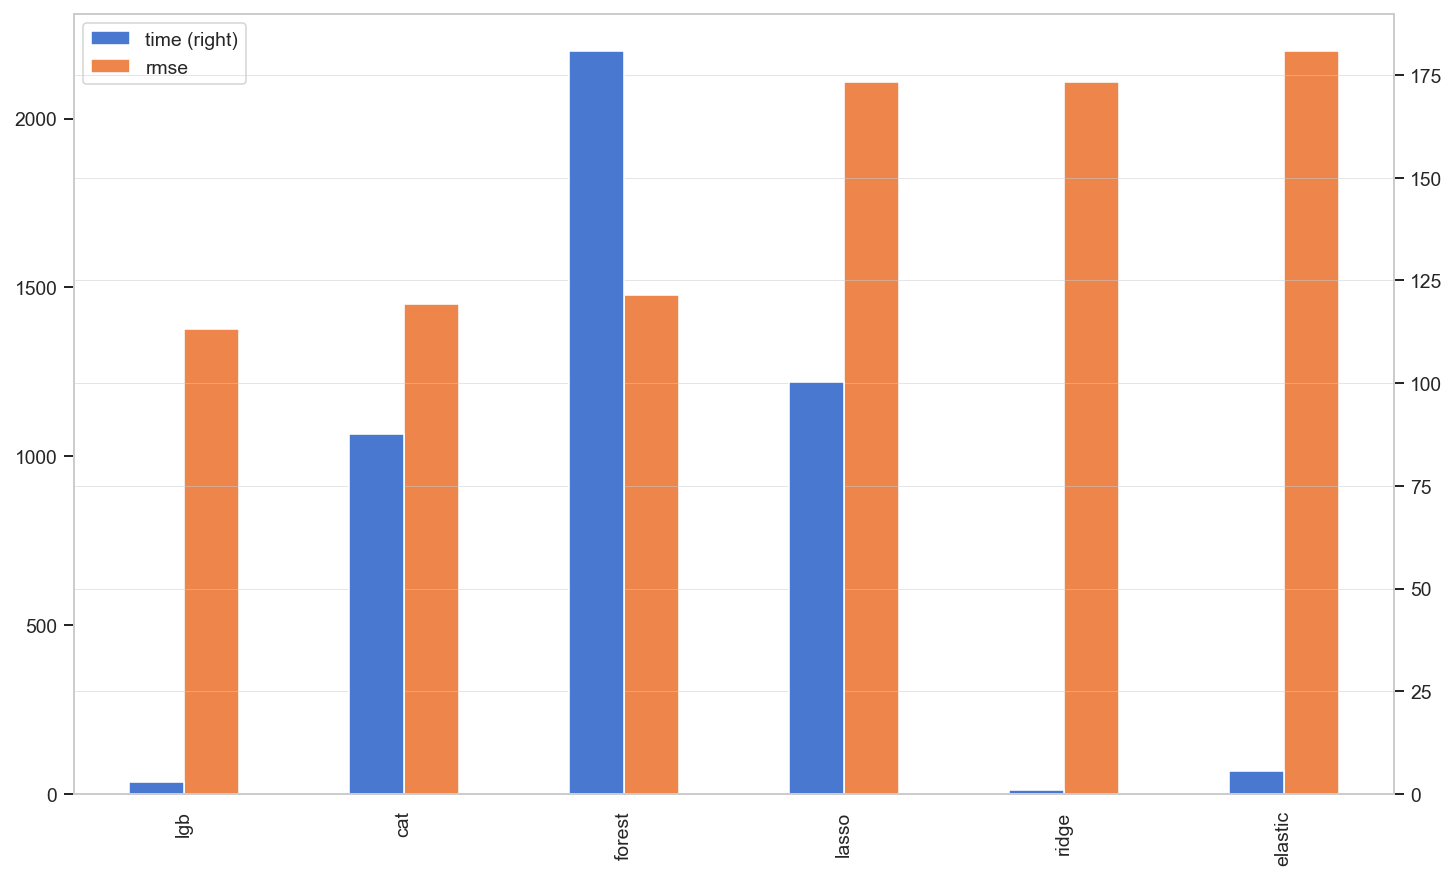

In [31]:
results[['time','rmse']].sort_values(['rmse']).plot.bar(secondary_y='time');

Посмотрим, как точно работает модель для разных ценовых групп.

* Для самых дешевых авто RMSE низкая, но погрешность может составлять половину стоимости машины.
* Далее RMSE снижается, а доля ошибки нивелируется.

In [32]:
# Предскажем цену.
lgb_booster = lgb.train(params=params, train_set=train_set)
y_hat = lgb_booster.predict(X_test)

# Соединим реальные и предсказанные результаты.
compare_res = pd.concat([y_test.reset_index(drop=True),
                         pd.Series(y_hat)], axis=1)

# Разделим цены авто на 10 корзин.
compare_res['bins'] = pd.cut(compare_res['Price'], 10, include_lowest=True)

# Функция чтобы найти RMSE для групп.
def rmse(df):
    return pd.Series.count(df.iloc[:, 0]), \
           mean_squared_error(df.iloc[:, 0],
                              df.iloc[:, 1],
                              squared=False)
# Результат.
compare_res.groupby('bins').apply(rmse)

bins
(490.509, 2459.0]      (17202, 749.947475381894)
(2459.0, 4408.0]      (9878, 1116.8928481114174)
(4408.0, 6357.0]      (6270, 1369.1370781397686)
(6357.0, 8306.0]      (4691, 1545.8226171516803)
(8306.0, 10255.0]     (3413, 1757.9897765563521)
(10255.0, 12204.0]    (2275, 1897.7526451110452)
(12204.0, 14153.0]    (1874, 2039.2577860717888)
(14153.0, 16102.0]    (1459, 2255.8190025164704)
(16102.0, 18051.0]    (1120, 2357.6906569255207)
(18051.0, 20000.0]     (866, 3027.9422320008835)
dtype: object

# Выводы:

* Разработана модель для определения стоимости авто на основе исторические данные.
* Проведен сравнительный анализ по качеству предсказания, скорости и времени обучения.
* Выбрана оптимальная модель, подобраны гиперпараметры.